# Simulating blazar light curves

This notebook explains how to use the <code>lcsim.py</code> module to create artificial blazar light curves. While all available functions and various options these functions provide are demonstrated, this notebook is not a detailed documentation of the functions. For details on the function parameters read the docstrings or use <code>help()</code>.

The goal is to simulate data that looks similar to typical blazar light curves, i.e. has the same same variability characteristics.

As an example we want to emulate the behavior at 15 GHz as seen in the sample of sources that is observed with the OVRO 40m Telescope.

Without a clear, concise understanding of the flaring behavior of jets, we treat light curves as a random noise process, characterized by the Probability Density Function (PDF) in time domain and the Power Spectral Density (PSD) in the frequency domain.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scipy.stats as stats
from statsmodels.distributions import ECDF
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'axes.labelsize': 20.,
                     'axes.titlesize': 20.,
                     'figure.figsize': [16, 5],
                     'font.family': 'serif',
                     'legend.fontsize': 16.,
                     'legend.numpoints': 1,
                     'legend.scatterpoints': 1,
                     'lines.linewidth': 1.,
                     'lines.marker': 'o',
                     'lines.markersize': 6,
                     'lines.linestyle': 'None',
                     'xtick.labelsize': 16.,
                     'ytick.labelsize': 16.})

The following module allows us to create artificial light curves that follow a given PSD and PDF:

In [4]:
import lcsim

## The <code>LightCurveSimulator</code> class

The included example radio light curve covers about 8 years of observations. Let's say we want to simulate light curves 10 years long. The simulation algorithm only covers frequencies between those corresponding to the total time (lowest frequency) and the time sampling (highest frequency). However, for realistic light curves we want to include power at frequencies outside of these sampling limits. To include power at higher frequencies we start with a time sampling much denser than the what we finally are interested in. E.g. if we want on average daily samples, we start with a time sampling of 10 data points per day. To include power at lower frequencies we need to initially simulate a much longer light curve. For this we set the `leakage` parameter larger than 1. The initially simulated light curve will have a duration of the total time multiplied with this factor. E.g. a factor 10 will include power at frequencies ten times longer than that corresponding to the total time of the final simulated light curves.

We create an instance of the <code>LightCurveSimulator</code> class:

In [5]:
time_total = 365. * 10. # days
time_sampling = 0.1     # days
leakage = 10.

sim = lcsim.LightCurveSimulator(time_total, time_sampling, leakage=leakage)

### Simulating Gaussian noise

The <a href="http://adsabs.harvard.edu/abs/1995A%26A...300..707T">Timmer & Koenig, 1995</a> (TK) paper introduced an algorith to create Gaussian noise that follows a specified PSD. This algorithm is implemented in the <code>sim_tk()</code> method.

It is generally claimed that blazar light curves follow a red noise process (at least as first order approximation), i.e. that the PSD can be described by a power-law:

$ P(\nu) = A \left(\frac{\nu}{\nu_0}\right)^{-\beta}$

The <code>LightCurveSimulator</code> provides several options for a spectral shape, but we are using the simple convention of a power-law, providing three parameters: the spectral index $\beta$ and the amplitude $A$ at frequency $\nu_0$. Note: $A$ and $\nu_0$ are basically irrelevant, because the spectrum will be rescaled in a later step. 

In [6]:
spec_shape = sim.powerlaw
spec_args = [2.3, 10, 10**(-7)] # power of 10. at 10^-7 gives a fairly stable LC amplitude scale, independent of index
nlcs = 10

sim.sim_tk(spec_shape, spec_args, nlcs=nlcs, seed=False)

**Initial time sampling:** The way this algorithm works, the simulated data follows a power spectrum in the frequency range $\nu_{\Delta T} = \left(\Delta T\right)^{-1}$ to $\nu_T = T^{-1}$, where $\Delta T$ is the time sampling step and $T$ is the total time of the data. Real light curves also show variability on time scales shorter than $\Delta T$ and longer than $T$ (under the assumption of the power-law PSD. Thus, we want the simulated data to resemble the same behavior.

Increasing $T$ and decreasing $\Delta T$ by a factor of 10 is mostly sufficient (<a href="https://kups.ub.uni-koeln.de/6231/">Kiehlmann, 2015</a>).

By setting <code>nlcs = 10</code> we simulate 10 artificial light curves. In fact, the code first produces one long light curve that is 10 times longer than the target duration and then splits the result into 10 individual simulations. Thus, we ensure that power down to a frequency of $\left(10 \cdot T\right)^{-1}$ is included in the power spectrum.

The target cadence of the OVRO 40m Monitoring Campaign is two observations per week, say 3 days. Some sources are observed daily. Here we use a time sampling of 0.1 days, thus including power up to frequencies much higher than our target time step.
Another reason for a high initial cadence is that we want to resample the data in a later step. When we simulate uneven time steps (as it is typical for the data) this is done by linear interpolation. That means inventing data points. To keep the interpolated data points as realistic as possible, a short initial time step is useful.


Now, we have simulated 10 light curves. <code>get_lcs()</code> give us the results in a list. Each list item is an <code>ArtificialLightCurve</code> instance; more on those later. Let's take the first one and plot the result:

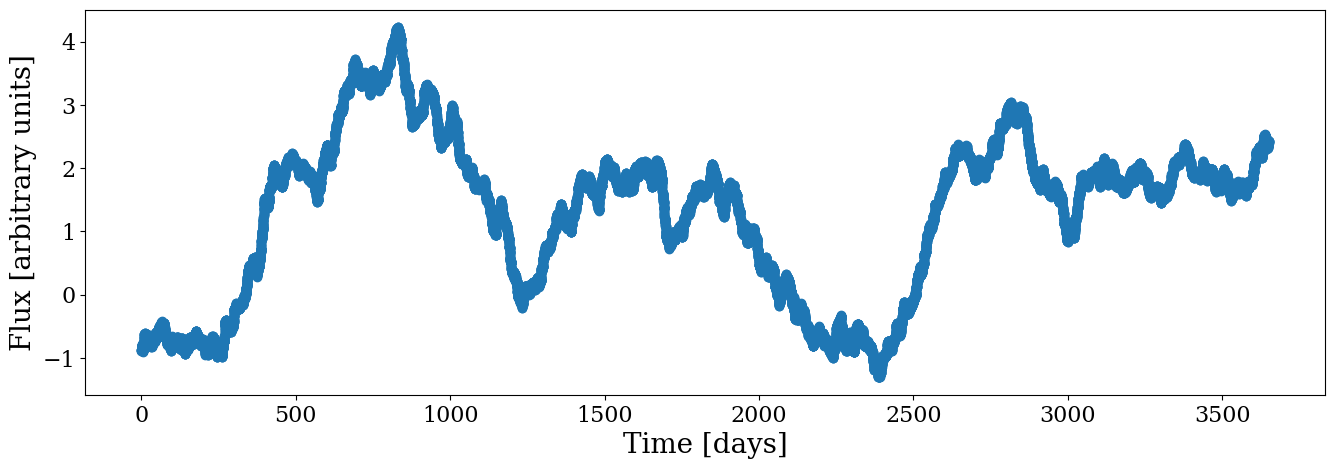

In [7]:
lcs = sim.get_lcs()
lc = lcs[0]
data = lc.data()

plt.plot(data['time'], data['flux'])
plt.xlabel('Time [days]')
plt.ylabel('Flux [arbitrary units]')
pass

### Matching the mean and standard deviation of a source

Light curves produced as above have zero mean, which of course is not realistic. We can simply rescale the light curve(s) such that they have a predefined standard deviation and add an offset to shift the mean from zero. First we load a real light curve:

(0.0, 2.0)

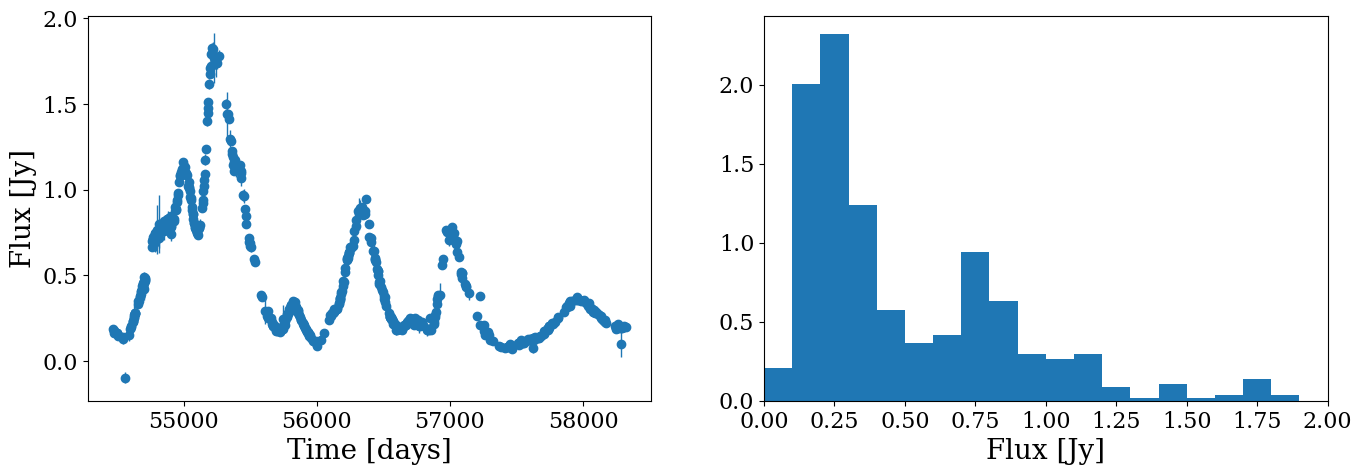

In [8]:
source_data = np.loadtxt(
        'demo/J0010+1058.csv', delimiter=',', dtype=[('mjd', float), ('flux', float), ('flux_unc', float)])

__, ax = plt.subplots(1, 2)
ax[0].errorbar(source_data['mjd'], source_data['flux'], yerr=source_data['flux_unc'], marker='o')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux [Jy]')
ax[1].hist(source_data['flux'], bins=20, range=(0, 2), density=True)
ax[1].set_xlabel('Flux [Jy]')
ax[1].set_xlim(0, 2)

In [9]:
lc_mean = np.mean(source_data['flux'])
lc_std = np.std(source_data['flux'])
print(f'Mean: {lc_mean:6.2f} Jy')
print(f'Std:  {lc_std:6.2f} Jy')

Mean:   0.49 Jy
Std:    0.37 Jy


Now, we can rescale and shift all artificial light curves to match these values by using the `rescale()` method:

In [10]:
sim.rescale(lc_mean, lc_std)

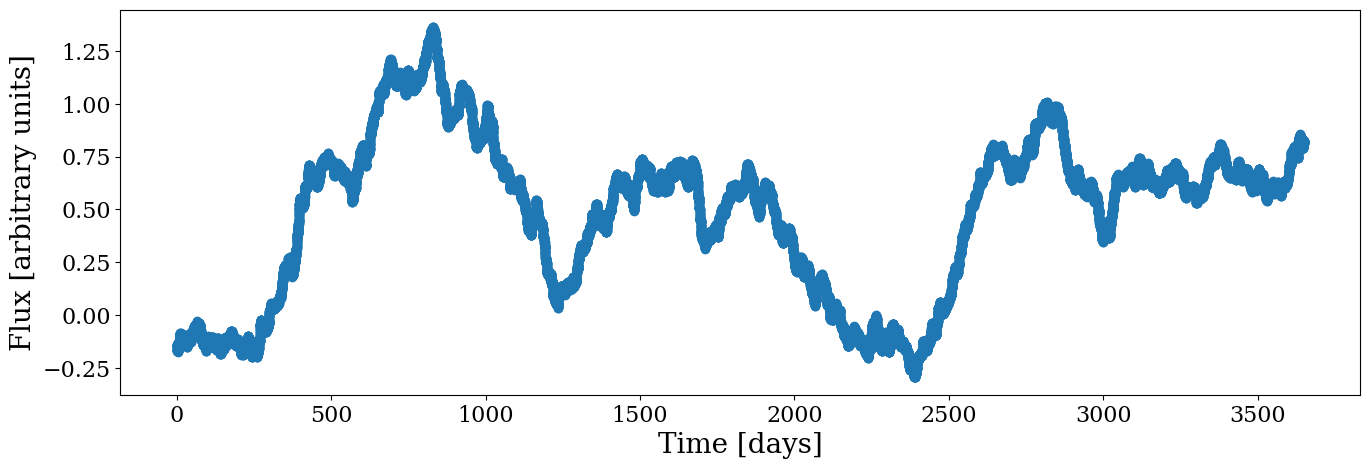

In [11]:
lcs = sim.get_lcs()
lc = lcs[0]
data = lc.data()

plt.plot(data['time'], data['flux'])
plt.xlabel('Time [days]')
plt.ylabel('Flux [arbitrary units]')
pass

The artificial light curve is the same as shown further above, but it is now covering a different range. We still get negative flux density values (probably; this is a randomly generated light curve). The reason is that the T&K95 light curves are Gaussian distributed, but blazar light curves often are not. The distribution above for the real data clearly is non-Gaussian. Therefore, simply rescaling and shifting the artificial light curve does not do a good job.

### Checking the PDF

The `check_pdf()` method allows us to test whether or not a simulated light curve is consistent with an expected PDF. This is simply done with a KS-test. With the first argument we set a threshold for the p-value. This threshold sets which simulations are accepted, which are rejected. With the second parameter we provide a reference PDF. Below we simply provide the flux density data from the real light curve, this will be used in a 2-sample KS-test. Alternatively, it is also possible to give a reference distribution e.g. `scipy.stats.lognorm()`, the distribution parameters need to be given to the argument `args`. All simulated light curves will be tested and flagged as accepted or rejected. With `verbose=1` the script prints out information about the number of simulations rejected and the acceptance rate:

In [12]:
sim.check_pdf(0.05, source_data['flux'], verbose=1);

10 LCs rejected out of 10. Acceptance rate: 0.0 %.


Artifical light curves are now flagged:

In [13]:
lcs = sim.get_lcs()
lc = lcs[0]
print(lc)

Artificial light curve
Simulation type:                TK
Original time sampling:      0.100
Original total time:      3650.000
PDF checked-----------------------
p-value:                   0.00000
Accepted:                    False



When we set `drop=True` rejected light curves are automatically removed from the class instance:

In [14]:
sim.check_pdf(0.05, source_data['flux'], drop=True, verbose=1);

10 LCs rejected out of 10. Acceptance rate: 0.0 %.


In [15]:
lcs = sim.get_lcs()
print(len(lcs))

0


### Adapting a realistic PDF

Let's take another look at the real light curve shown already above. The histogram shows this is clearly not a Gaussian PDF and the Shapiro-Wilk test confirms that with high confidence.

Shapiro-Wilk test for normality, p-value: 1.14e-22


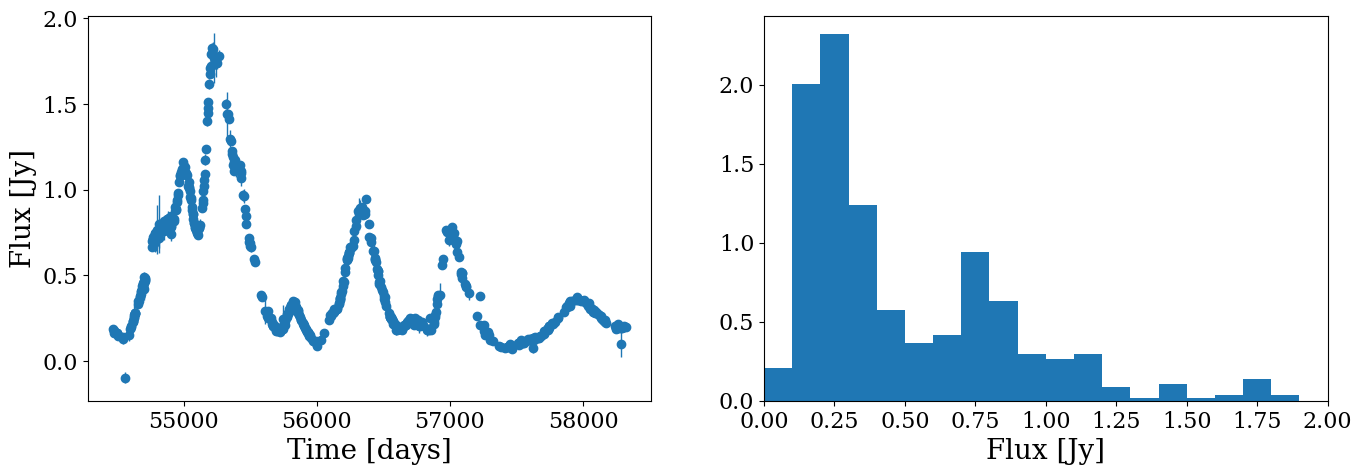

In [16]:
__, ax = plt.subplots(1, 2)
ax[0].errorbar(source_data['mjd'], source_data['flux'], yerr=source_data['flux_unc'], marker='o')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Flux [Jy]')
ax[1].hist(source_data['flux'], bins=20, range=(0, 2), density=True)
ax[1].set_xlabel('Flux [Jy]')
ax[1].set_xlim(0, 2)

print('Shapiro-Wilk test for normality, p-value: {0:.2e}'.format(stats.shapiro(source_data['flux'])[1]))

<a href="http://adsabs.harvard.edu/abs/2013MNRAS.433..907E">Emmanoulopoulos, McHardy & Papadakis, 2013</a> (EMP) introduced an alogrithm that takes a Gaussian light curve as produced by the TK method and iteratively changes its normal PDF into the target PDF, while preserving the PSD.

This algorithm is implemented in the <code>adjust_pdf()</code> method. This method is automatically applied to every light curve currently stored in the <code>LightCurveSimulator</code> instance. Given that the algorithm is an iterative process and we want to avoid infinite loops we limit the iterations to <code>iterations=100</code>.

Let's use the Empirical Cumulative Distribution Function (ECDF) of the light curve above as a template PDF and apply it to the simulated light curves. First, we create new T&K95 simulations, because we probably deleted them above.

In [17]:
spec_shape = sim.powerlaw
spec_args = [2.3, 10, 10**(-7)] # power of 10. at 10^-7 gives a fairly stable LC amplitude scale, independent of index
nlcs = 10

sim.sim_tk(spec_shape, spec_args, nlcs=nlcs, seed=False)

Now, we can adjust the PDF:

In [18]:
sim.adjust_pdf(
        source_data['flux'], pdf_params=None, pdf_range=None,
        iterations=400, keep_non_converged='ask', threshold=0.01)

Let's take a look at the result. This is the first light curve:

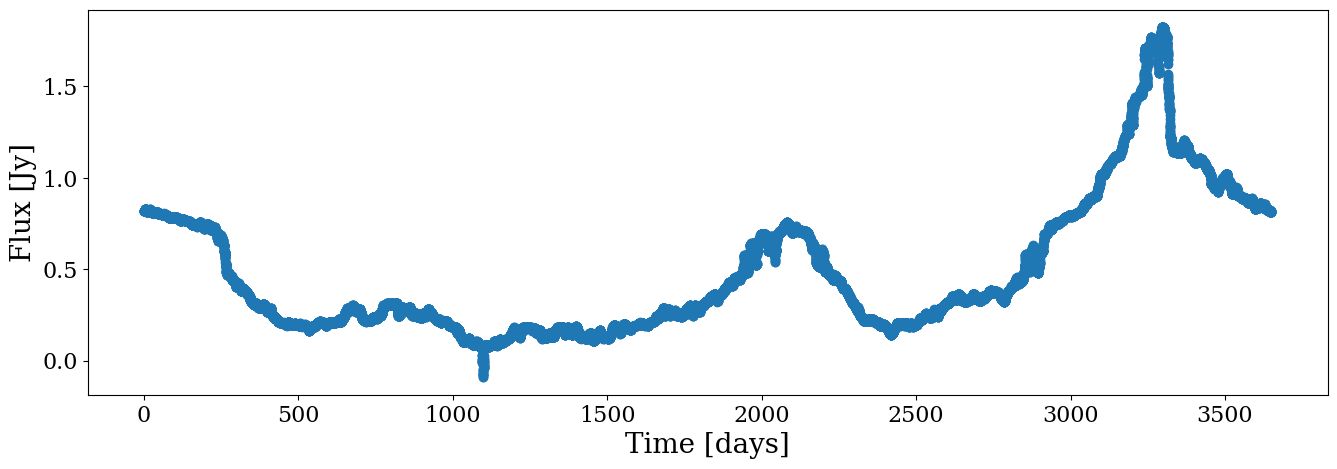

In [19]:
lcs = sim.get_lcs()
lc = lcs[0]
data = lc.data()

plt.plot(data['time'], data['flux'])
plt.xlabel('Time [days]')
plt.ylabel('Flux [Jy]')
pass

It (supposedly$^*$) still has the same PSD as the artificial Gaussian light curve shown above, but now is has the same PDF as the example source:

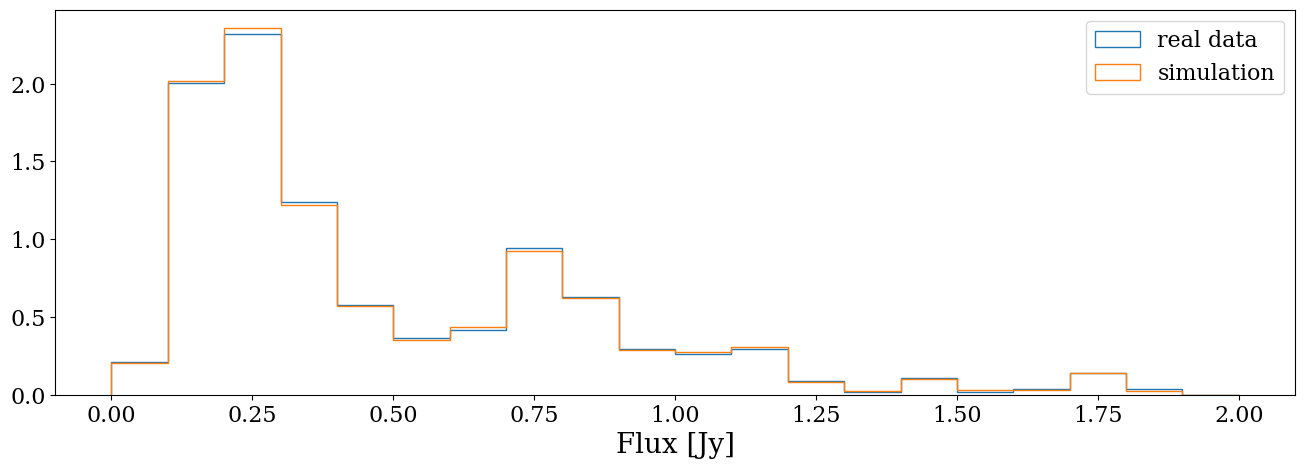

In [20]:
plt.hist(source_data['flux'], bins=20, range=(0, 2), density=True, histtype='step', label='real data')
plt.hist(data['flux'], bins=20, range=(0, 2), density=True, histtype='step', label='simulation')
plt.xlabel('Flux [Jy]')
plt.legend(loc='best')
pass

We can run the PDF check again and should find a 100 % acceptance rate:

In [21]:
sim.check_pdf(0.05, source_data['flux'], verbose=1);

0 LCs rejected out of 10. Acceptance rate: 100.0 %.


$^*$) <a href="https://kups.ub.uni-koeln.de/6231/">Kiehlmann, 2015</a> discussed that this algorithm does not always preserve the PSD, depending on the initial slope of the PSD.

Using the ECDF of a real light curve as input to the EMP algorithm works well to produce a simulated light curve that actually has the same ECDF. But the ECDF is not an optimal estimator of the PDF. For example, one of the OVRO light curves had a long time gap during the rise of the flux density, resulting in a large gap in the empirical PDF, i.e. a plateau in the ECDF. This exact gap will show up in every simulated light curve that uses this ECDF as input to the EMP algorithm. Clearly, this is not what we want, as the gap is a sampling artifact.

The PDFs of the OVRO light curves can be reasonably well described by a superposition of several log-normal components, where the number of components is part of the fitting process.

Let's take one example (J2204+3632) with two components. The parameters come in triplets: peak position, peak amplitude, peak width:

In [22]:
pdf_params = [0.4842,1.1388,0.2773,1.0646,1.9084,0.1983]

sim.sim_tk(spec_shape, spec_args, nlcs=nlcs, seed=False)
sim.adjust_pdf(
        sim.multi_logn, pdf_params=pdf_params, pdf_range=[0.01, 10.],
        iterations=100, keep_non_converged='ask', threshold=0.01)

No convergence reached within 100 iterations. Keep (y), throw away (n), or try again (r)? y


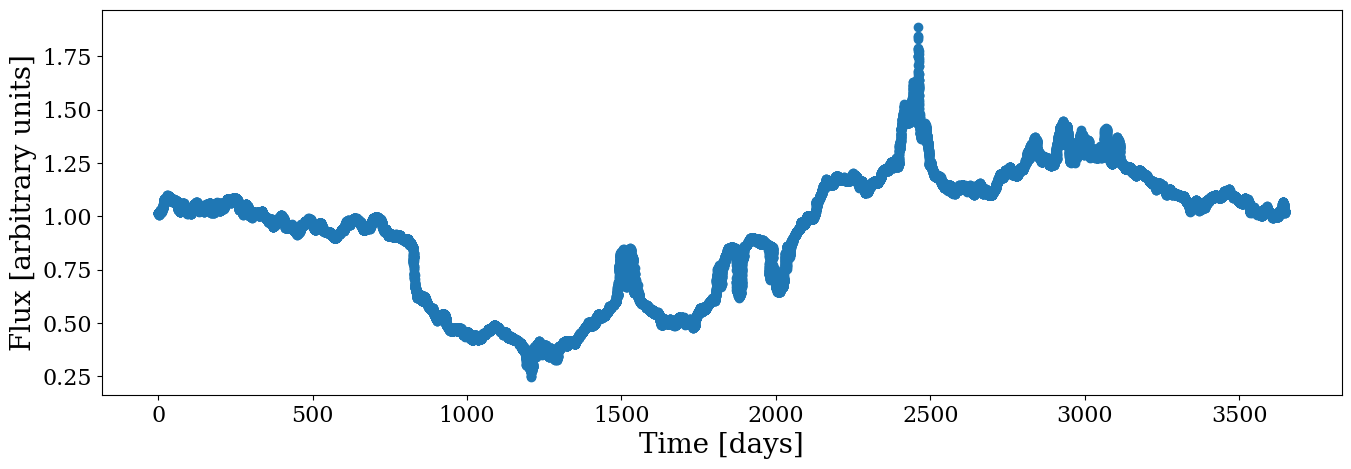

In [23]:
lcs = sim.get_lcs()
lc = lcs[0]
data = lc.data()

plt.plot(data['time'], data['flux'])
plt.xlabel('Time [days]')
plt.ylabel('Flux [arbitrary units]')
pass

/home/skiehl/Projects/Python/Astrotools/lcsim/lcsim.py:830: RuntimeWarning: divide by zero encountered in log
  y = y + amp * np.exp( -((np.log(x) - np.log(pos)) / wid)**2)


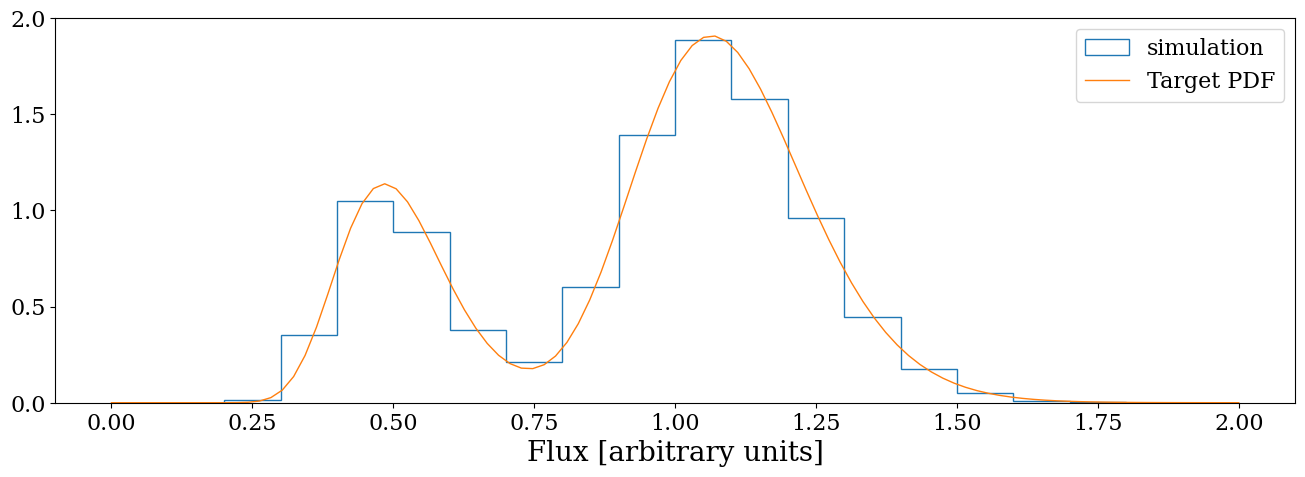

In [24]:
plt.hist(data['flux'], bins=20, range=(0, 2), density=True, histtype='step', label='simulation')
x = np.linspace(0, 2, 100)
y = sim.multi_logn(x, *pdf_params)
plt.plot(x, y, linestyle='-', marker='None', label='Target PDF')
plt.xlabel('Flux [arbitrary units]')
plt.legend(loc='best')
pass

To get a light curve with a specified PSD and PDF we ran two steps

<code>sim_tk(spec_shape, spec_args, nlcs=1, seed=False)
adjust_pdf(pdf, pdf_params=None, pdf_range=None, iterations=100, keep_non_converged=False, threshold=0.01)
</code>

The following method combines both:

In [25]:
sim.sim_emp(spec_shape, spec_args, sim.multi_logn, pdf_params=pdf_params, pdf_range=[0.01, 10.],
        nlcs=nlcs, iterations=100, keep_non_converged='ask', threshold=0.01)

## The <code>ArtificialLightCurve</code> class

The <code>LightCurveSimulator</code> method <code>get_lcs()</code> returns a list of the simulated light curves, each list entry being an instance of the <code>ArtificialLightCurve</code> class. Lets's take a look at the first simulated light curve. The <code>ArtificialLightCurve</code> method <code>data()</code> returns the simulated data in a dictionary, which is what we have used above to plot the data. The dictionary entries are numpy arrays.

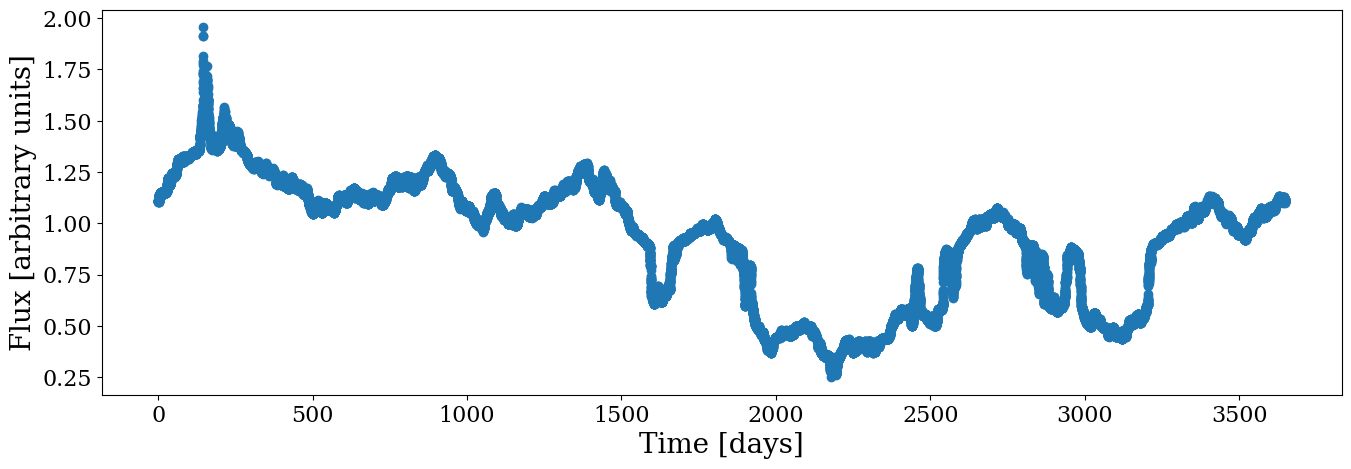

In [26]:
lcs = sim.get_lcs()
lc = lcs[0]

data = lc.data()

plt.plot(data['time'], data['flux'])
plt.xlabel('Time [days]')
plt.ylabel('Flux [arbitrary units]')
pass

Using <code>print</code> on an <code>ArtificialLightCurve</code>-instance print out general information about the simulated data:

In [27]:
print(lc)

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000



With the methods above we have simulated high-cadence, evenly sampled data. The <code>LightCurveSimulator</code> allows to further refine the simulation.

### Re-sampling the simulations

The method <code>resample()</code> gives several options to re-sample the simulated light curve to even or uneven time steps.
Typically, the simulated data is interpolated linearly to the new time steps. As explained above, this is one of the two reasons why we want to start of with high cadence simulations.

#### Re-sample to even time steps

Note: Once the artificial light curve has been re-sampled additional information is printed out when you call <code>print</code> on the instance.

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                   even
Time sampling:              10.000
Total time:               3650.000



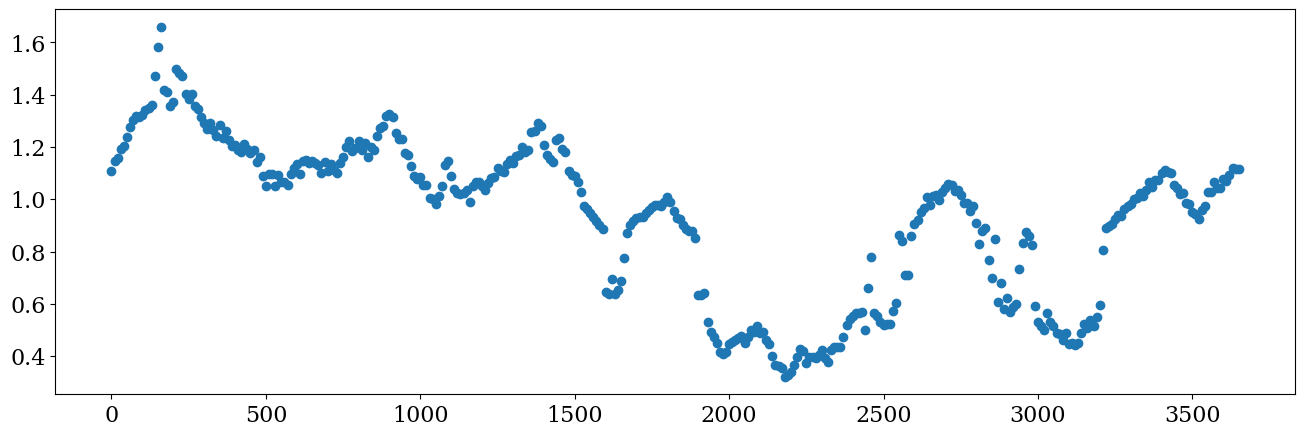

In [28]:
lc.resample(10.)

data = lc.data()
plt.plot(data['time'], data['flux'], marker='o')
print(lc)

#### Re-sample to uneven time steps

Note: When you call <code>resample()</code> again any former re-sampled data is overwritten. The original data is always kept internally, which is why you can re-sample it as ofter as you want.

You can specify two different distributions (powerlaw and lognormal) to draw random time steps (i.e. the time difference between data points):

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             powerlaw
Median time sampling:        7.026
Total time:               3642.757

Data points: 416
Min time step:    5.0
Max time step:   49.3


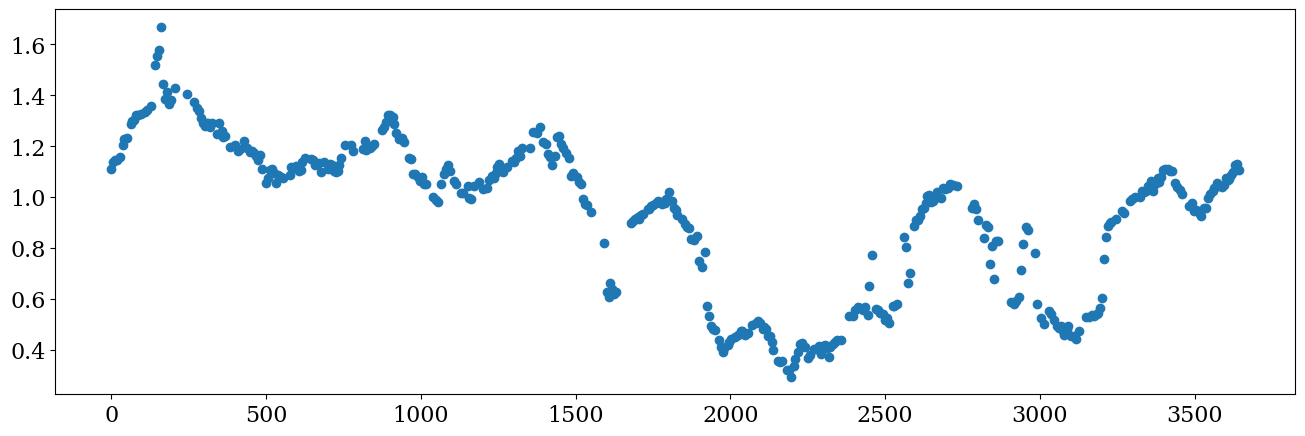

In [29]:
lc.resample('powerlaw', params=[-3., 5., 50.])

data = lc.data()
plt.plot(data['time'], data['flux'], marker='o')
print(lc)

print('Data points: {0:d}'.format(lc.size))
deltat = np.diff(data['time'])
print('Min time step: {0:6.1f}'.format(np.min(deltat)))
print('Max time step: {0:6.1f}'.format(np.max(deltat)))

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:            lognormal
Median time sampling:       16.241
Total time:               3646.054

Data points: 211
Min time step:    6.1
Max time step:   53.4


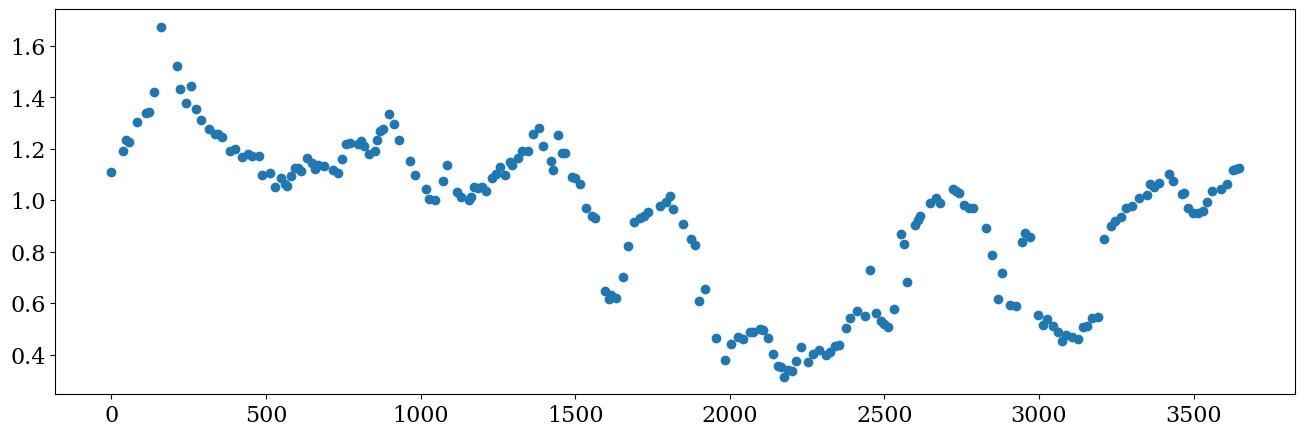

In [30]:
lc.resample('lognormal', params=[2.7, 0.4])

data = lc.data()
plt.plot(data['time'], data['flux'], marker='o')
print(lc)

print('Data points: {0:d}'.format(lc.size))
deltat = np.diff(data['time'])
print('Min time step: {0:6.1f}'.format(np.min(deltat)))
print('Max time step: {0:6.1f}'.format(np.max(deltat)))

Alternatively, you can give real time steps (i.e. the time difference between data points; for demonstration I draw these from a normal distribution here) and the simulated time steps will be randomly sample from the ECDF:

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:                 ecdf
Median time sampling:        9.864
Total time:               3649.050

Data points: 377
Min time step:    5.3
Max time step:   15.4


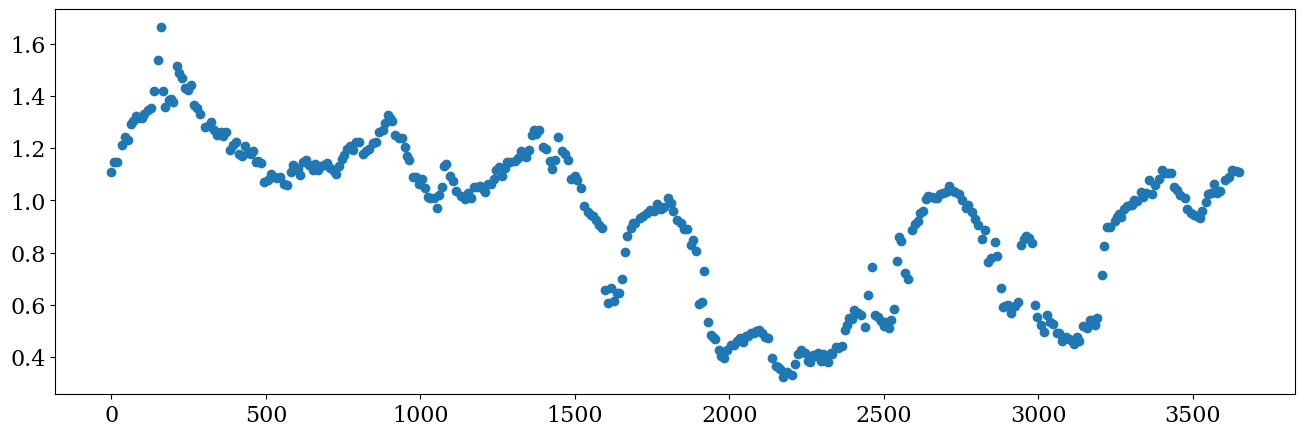

In [31]:
time_steps = np.random.normal(10, 2, size=100)
lc.resample('ecdf', params=time_steps)

data = lc.data()
plt.plot(data['time'], data['flux'], marker='o')
print(lc)

print('Data points: {0:d}'.format(lc.size))
deltat = np.diff(data['time'])
print('Min time step: {0:6.1f}'.format(np.min(deltat)))
print('Max time step: {0:6.1f}'.format(np.max(deltat)))

Or you can give time stamps (here for demonstration I draw random time steps from a normal distibution and sum them up cummulatively). The artificial data will be resampled at those time stamps. Note that the simulations start at time 0 and the simulation will be cut off, if the input time stamps exceed the total time of the simulation.

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             specific
Median time sampling:        9.947
Total time:               3645.479

Data points: 368
Min time step:    4.4
Max time step:   15.3


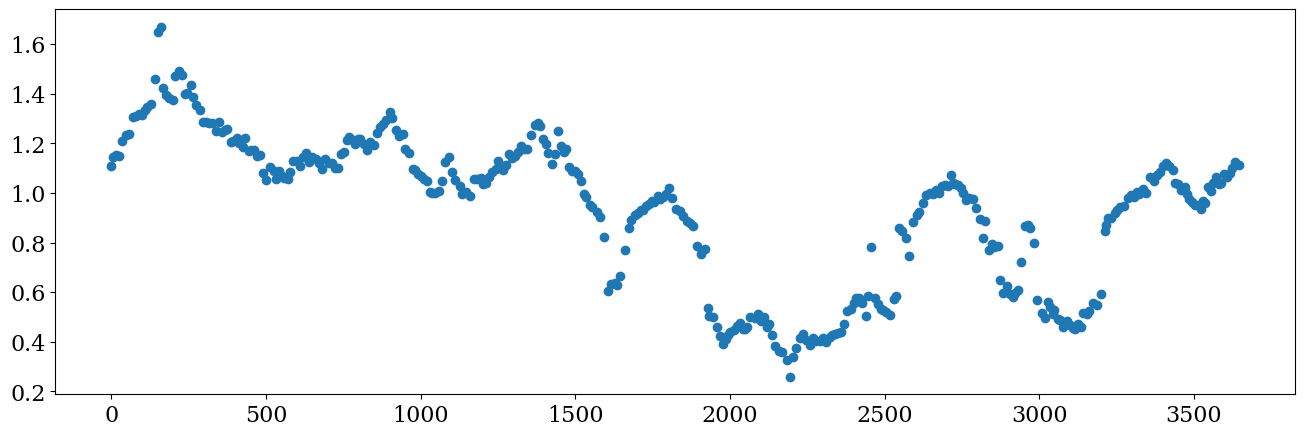

In [32]:
time_steps = np.random.normal(10, 2, size=500)
time_steps = np.cumsum(time_steps)
lc.resample(time_steps)

data = lc.data()
plt.plot(data['time'], data['flux'], marker='o')
print(lc)

print('Data points: {0:d}'.format(lc.size))
deltat = np.diff(data['time'])
print('Min time step: {0:6.1f}'.format(np.min(deltat)))
print('Max time step: {0:6.1f}'.format(np.max(deltat)))

### Adding "measurement" uncertainties:

Real data is always affected by uncertainties. You may want the same for the simulations to end up with "realistic" artificial data. <code>add_errors()</code> allows to add Gaussian noise. Other noise processes are currently not implemented.

For a given uncertainty scale $\sigma_i$ a random value $f_{\mathrm{err}, i} \sim \mathcal{N}(0, \sigma_i)$ is drawn and added to the simulated flux: $f_{\mathrm{sim}, i} \rightarrow f_{\mathrm{sim}, i} + f_{\mathrm{err}, i}$.

You can set homoscedastic errors by setting the same uncertainty $\sigma$ for all data points or heteroscedastic errors by supplying an uncertainty scale for each data point or a distribution for the uncertainty scale.


Notes: 
* You can call <code>add_errors()</code> as often as you want. The uncertainties are always applied to the latest re-sampled light curve (or the original one, if it has not been re-sampled) and do not add up.
* If you re-sample the light curve this will remove the added uncertainties and you need to repeat adding errors. * Additional info is printed out when uncertainties have been added and you call <code>print</code> on the <code>ArtificialLightCurve</code>-instance.
* When uncertainties have been added <code>data()</code> returns an additional entry <code>'flux_unc'</code> with the  uncertainties.

#### Homoscedastic uncertainties

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             specific
Median time sampling:        9.947
Total time:               3645.479
Gaussian noise added--------------
Uncertainties:       homoscedastic
Median uncertainty:          0.050



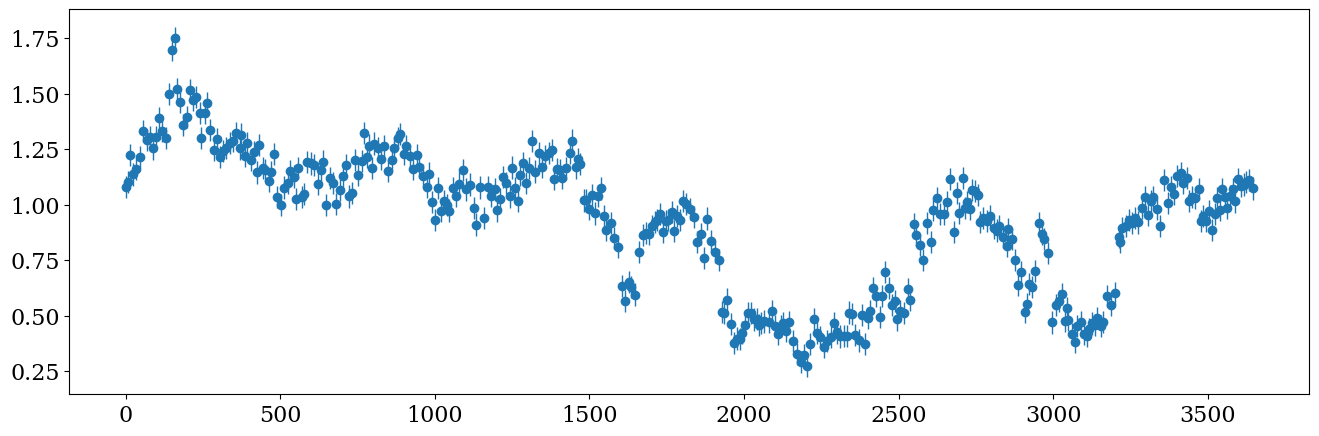

In [33]:
unc = 0.05
lc.add_errors(unc)

data = lc.data()
plt.errorbar(data['time'], data['flux'], data['flux_unc'], marker='o')
print(lc)

#### Heteroscedastic uncertainties

Either provide an uncertainty scale $\sigma_i$ for each data point in a numpy array.

For demonstration I set the uncertainties to 0.05, but for the first 100 data points twice as high. Which could be the case if the instrument or the data reduciont had improved at some point in time.

Note: If you run this code snippet again you will find that
1. The uncertainties are always the same, because those are specifically given for each data points;
2. The flux values will change, because the added noise is drawn randomly from a normal distribution.

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             specific
Median time sampling:        9.947
Total time:               3645.479
Gaussian noise added--------------
Uncertainties:     heteroscedastic
Distribution:             specific
Median uncertainty:          0.050



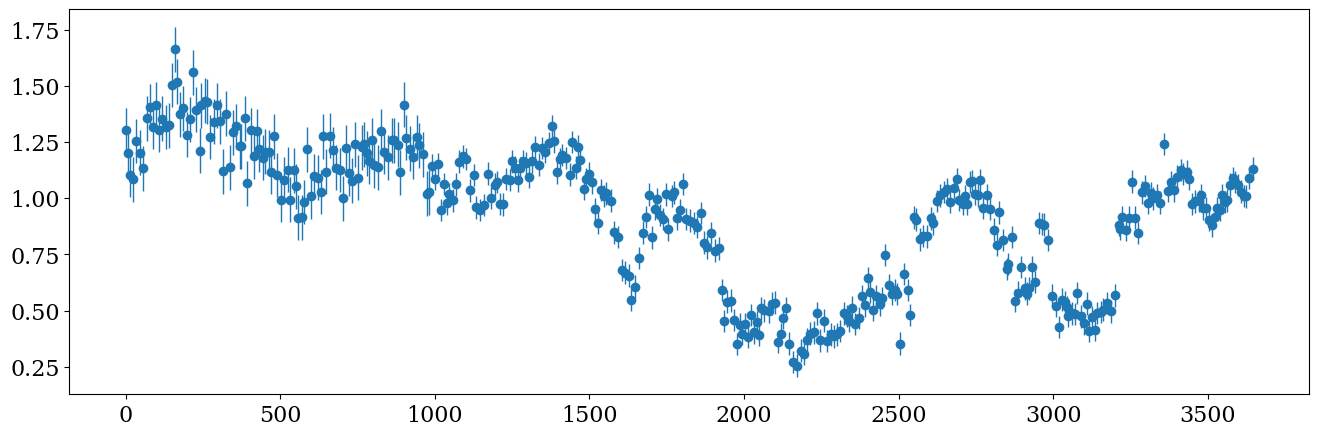

In [34]:
unc = np.ones(lc.size) * 0.05
unc[:100] *= 2

lc.add_errors(unc)

data = lc.data()
plt.errorbar(data['time'], data['flux'], data['flux_unc'], marker='o')
print(lc)

Alternatively, you can provide uncertainties from e.g. a real light curve and have simulated uncertainties randomly drawn from the ECDF of the provided uncertainties. For demonstration I create random uncertainties drawn from a lognormal distribution, but this could be estimated uncertainties from a real light curve.

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             specific
Median time sampling:        9.947
Total time:               3645.479
Gaussian noise added--------------
Uncertainties:     heteroscedastic
Distribution:                 ecdf
Median uncertainty:          0.018



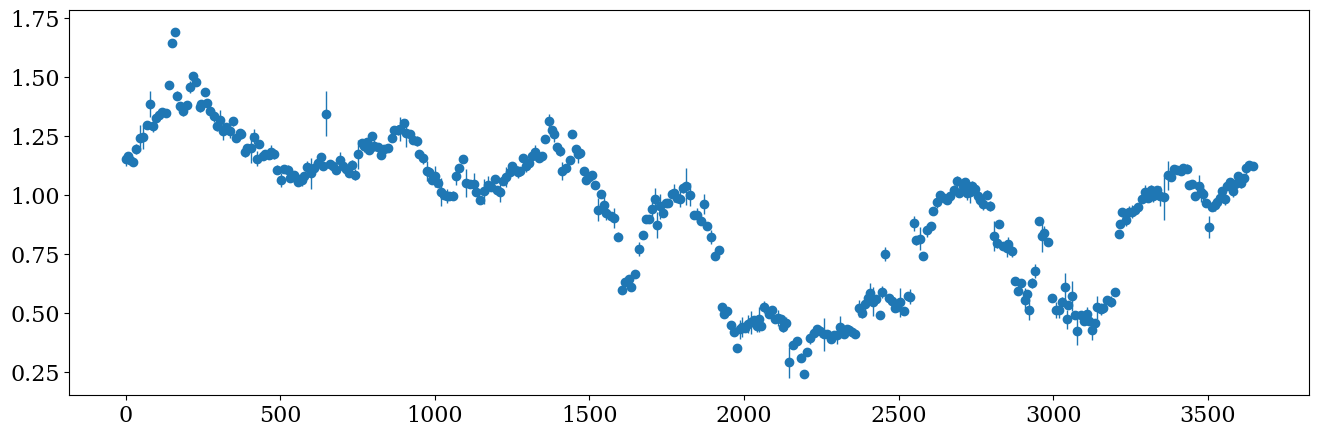

In [35]:
unc = np.random.lognormal(-4., 0.8, 100)
lc.add_errors('ecdf', params=unc)

data = lc.data()
plt.errorbar(data['time'], data['flux'], data['flux_unc'], marker='o')
print(lc)

As a third option you can have random uncertainties drawn from a log-normal distribution.

Artificial light curve
Simulation type:               EMP
Original time sampling:      0.100
Original total time:      3650.000
Resampled-------------------------
Time steps:                 uneven
Distribution:             specific
Median time sampling:        9.947
Total time:               3645.479
Gaussian noise added--------------
Uncertainties:     heteroscedastic
Distribution:            lognormal
Median uncertainty:          0.020



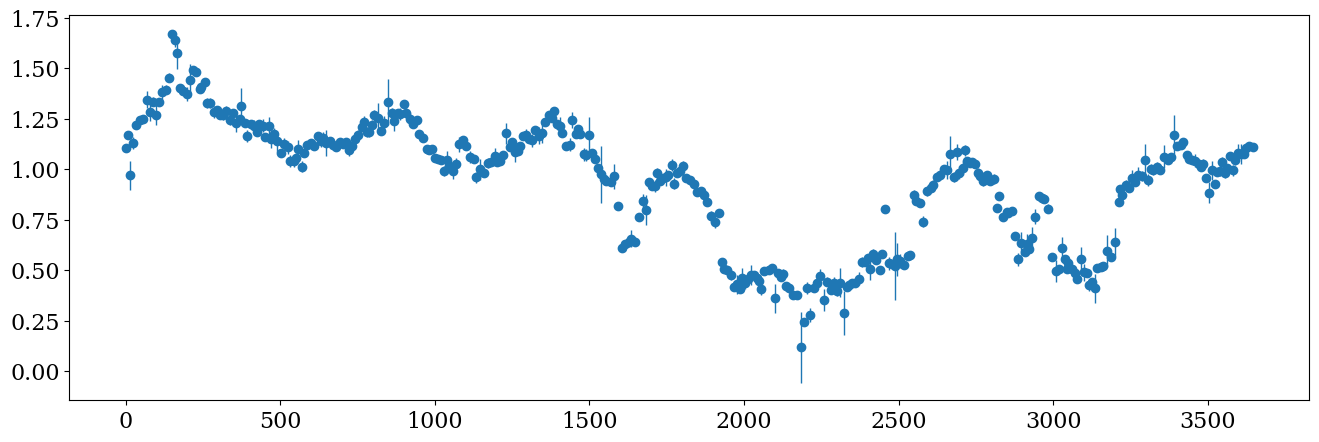

In [36]:
lc.add_errors('lognormal', params=(-4, 0.8))

data = lc.data()
plt.errorbar(data['time'], data['flux'], data['flux_unc'], marker='o')
print(lc)

### Getting the light curve data with <code>data()</code>

We have used the <code>ArtificialLightCurve.data()</code> method several times above to get the data out of the class instance to plot it. When called without arguments <code>data()</code> returns only the final light curve data, i.e. the resampled time and flux, if <code>resample()</code> was applied, and/or the flux data with added noise, if <code>add_errors()</code> was applied.

All steps of modifying the light curve are kept internally, in order to be able to change the time sampling or noise terms at any time. If you want to retrieve all versions of the light curve data use <code>data(get_all=True)</code>. Then 'time_orig' and 'flux_orig' contain the original light curve, 'time_res' and 'flux_res' contain the light curve re-sampled to a different time grid, 'flux_err' contains the re-sampled fluxes plus the noise, and 'flux_unc' contains the uncertainties (i.e. the error bars).

In [37]:
print(lc.data().keys())
print(lc.data(get_all=True).keys())

dict_keys(['time', 'flux', 'flux_unc'])
dict_keys(['time_orig', 'flux_orig', 'time_res', 'flux_res', 'flux_err', 'flux_unc'])
